# Token Generator
This code can get an idea of what features we want and generate tokens based on that. 

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_scatter(df, dim_x, dim_y, title=None):
    """
    Scatter plot of two feature dimensions from the dataframe.
    
    df     : pandas DataFrame from tokens_to_df()
    dim_x  : feature name for x-axis
    dim_y  : feature name for y-axis
    title  : optional plot title
    """
    plt.figure(figsize=(6, 6))
    
    # If multiple phonemes appear, color by phoneme
    phonemes = df["phoneme"].unique()
    
    for phon in phonemes:
        sub = df[df["phoneme"] == phon]
        plt.scatter(sub[dim_x], sub[dim_y], label=phon, alpha=0.7)

    plt.xlabel(dim_x)
    plt.ylabel(dim_y)
    
    if title:
        plt.title(title)
    
    if len(phonemes) > 1:
        plt.legend()

    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [22]:
import warnings

def check_missing_sd_columns(df):
    """
    Check that each feature column has a corresponding *_SD column.
    Warns if any SD column is missing.
    """
    # Identify feature and SD columns
    feature_cols = [col for col in df.columns if col != "phoneme" and not col.endswith("_SD")]
    sd_cols = {col: col for col in df.columns if col.endswith("_SD")}

    missing = []

    for feature in feature_cols:
        sd_name = feature + "_SD"
        if sd_name not in sd_cols:
            missing.append(sd_name)

    if missing:
        warnings.warn(
            f"The following features are missing SD columns: {missing}",
            UserWarning
        )

    return missing


In [58]:
import pandas as pd
import numpy as np

def generate_phoneme_tokens_slow(csv_path, phoneme_symbol, num_tokens, to_df=True):
    if isinstance(csv_path, str): 
        # Load the CSV file
        df = pd.read_csv(csv_path)
    elif isinstance(csv_path, pd.DataFrame): 
        df = csv_path
    else: 
        raise TypeError("csv_path must either be a string or pandas df! ")
    
    # Make sure the phoneme column is present
    if 'phoneme' not in df.columns:
        raise ValueError("The CSV must contain a 'phoneme' column.")
    
    missing = check_missing_sd_columns(df)
    
    # Filter the dataframe for the given phoneme symbol
    phoneme_data = df[df['phoneme'] == phoneme_symbol]
    
    if phoneme_data.empty:
        raise ValueError(f"No data found for phoneme symbol: {phoneme_symbol}")
    
    # Identify feature columns (everything except phoneme and *_SD columns)
    feature_cols = [col for col in df.columns if col != 'phoneme' and not col.endswith('_SD')]
    std_cols = {col: col for col in df.columns if col.endswith('_SD')}
    
    generated_tokens = []

    for pid in range(num_tokens):
        token = {
            "phoneme": phoneme_symbol,
            "pid": pid,
        }

        for feature in feature_cols:
            mean = phoneme_data[feature].values[0]
            sd_col = feature + "_SD"
            std = phoneme_data[sd_col].values[0] if sd_col in phoneme_data else 0

            token[feature] = np.random.normal(loc=mean, scale=std)

        generated_tokens.append(token)
    
    if to_df: 
        generated_tokens = pd.DataFrame(generated_tokens)
    
    return generated_tokens


def generate_phoneme_tokens(csv_path, phoneme_symbol, num_tokens, to_df=True):
    if isinstance(csv_path, str): 
        # Load the CSV file
        df = pd.read_csv(csv_path)
    elif isinstance(csv_path, pd.DataFrame): 
        df = csv_path
    else: 
        raise TypeError("csv_path must either be a string or pandas df! ")
    
    # Make sure the phoneme column is present
    if 'phoneme' not in df.columns:
        raise ValueError("The CSV must contain a 'phoneme' column.")
    
    # Optional: warn if SD columns are missing
    missing = check_missing_sd_columns(df)
    
    # Filter the dataframe for the given phoneme symbol
    phoneme_data = df[df['phoneme'] == phoneme_symbol]
    
    if phoneme_data.empty:
        raise ValueError(f"No data found for phoneme symbol: {phoneme_symbol}")
    
    # Identify feature columns (everything except phoneme and *_SD columns)
    feature_cols = [
        col for col in df.columns 
        if col != 'phoneme' and not col.endswith('_SD')
    ]
    
    # Get means for all features (vector)
    means = phoneme_data[feature_cols].iloc[0].to_numpy(dtype=float)
    
    # Build std vector aligned with feature_cols
    stds = []
    for feature in feature_cols:
        sd_col = feature + "_SD"
        if sd_col in phoneme_data.columns:
            stds.append(float(phoneme_data[sd_col].iloc[0]))
        else:
            stds.append(0.0)  # or raise, depending on how strict you want
    stds = np.array(stds, dtype=float)
    
    # Vectorized sampling: shape = (num_tokens, n_features)
    samples = np.random.normal(loc=means, scale=stds, size=(num_tokens, len(feature_cols)))
    
    # Build DataFrame
    df_features = pd.DataFrame(samples, columns=feature_cols)
    df_meta = pd.DataFrame({
        "phoneme": [phoneme_symbol] * num_tokens,
        "pid": np.arange(num_tokens, dtype=int),
    })
    
    result_df = pd.concat([df_meta, df_features], axis=1)
    
    if to_df:
        return result_df
    else:
        # preserve old behaviour: list of dicts
        return result_df.to_dict(orient="records")


### Improving speed: benchmark

In [59]:
import time

# --------------------------------------------------
# Benchmark function
# --------------------------------------------------
def benchmark(csv_df, phoneme="a", num_tokens=100000):
    print(f"Benchmarking with num_tokens = {num_tokens:,}\n")

    # Slow version
    t0 = time.perf_counter()
    generate_phoneme_tokens_slow(csv_df, phoneme, num_tokens)
    t1 = time.perf_counter()

    slow_time = t1 - t0
    print(f"Slow version: {slow_time:.4f} seconds")

    # Fast version
    t2 = time.perf_counter()
    generate_phoneme_tokens(csv_df, phoneme, num_tokens)
    t3 = time.perf_counter()

    fast_time = t3 - t2
    print(f"Fast version: {fast_time:.4f} seconds")

    print(f"\nSpeedup: {slow_time / fast_time:.2f}× faster")

In [62]:
benchmark('features.csv', 'a', 1000)

Benchmarking with num_tokens = 1,000

Slow version: 0.0175 seconds
Fast version: 0.0023 seconds

Speedup: 7.65× faster


### Test generate

In [63]:
# Example usage:
tokens = generate_phoneme_tokens('features.csv', 'a', 10000)

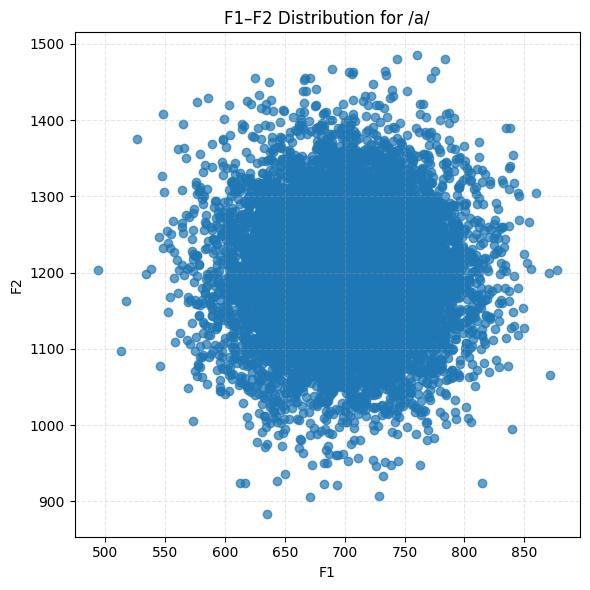

In [64]:
plot_feature_scatter(tokens, "F1", "F2", title="F1–F2 Distribution for /a/")

## Seq generation

In [ ]:
def generate_words_from_csv(words_csv_path, features_csv_path, default_count=1):
    words_df = pd.read_csv(words_csv_path)
    if 'word' not in words_df.columns:
        raise ValueError("The words.csv file must have a 'word' column.")
    
    features_df = pd.read_csv(features_csv_path)
    
    all_tokens = []
    current_cid = 0
    
    for _, row in words_df.iterrows():
        word = row['word']
        count = row.get('number', default_count)
        
        # Split the word into phonemes
        phonemes = list(word)
        
        for wid in range(count):    # word_id
            for pos, phoneme in enumerate(phonemes):
                # Generate phoneme tokens
                phoneme_tokens = generate_phoneme_tokens(features_df, phoneme, 1, to_df=False)
                
                for token in phoneme_tokens:
                    # Add word-level identifiers
                    token['word'] = word
                    token['wid'] = wid
                    token['cid'] = current_cid

                    pid = token["pid"]

                    # Create the identifier
                    # This will be something like "word_phoneme_position_cid"
                    token['identifier'] = f"{word}_{wid}_{pos}_{pid}"
                    
                    # Increment the global component ID
                    current_cid += 1
                    
                    # Add the token to the list
                    all_tokens.append(token)
    
    return pd.DataFrame(all_tokens)


In [74]:
import pandas as pd
import numpy as np

def generate_words_from_csv(words_csv_path, features_csv_path, default_count=1):
    # Load inputs
    words_df = pd.read_csv(words_csv_path)
    if 'word' not in words_df.columns:
        raise ValueError("words.csv must have a 'word' column.")

    if isinstance(features_csv_path, str):
        features_df = pd.read_csv(features_csv_path)
    else:
        features_df = features_csv_path

    all_tokens = []
    current_cid = 0

    # Loop *per word* (cannot avoid)
    for _, row in words_df.iterrows():
        word = row['word']
        count = row.get("number", default_count)

        phonemes = list(word)
        n_ph = len(phonemes)

        # For each word instance: wid = 0 .. count-1
        # Total phoneme tokens = count × n_ph
        total_tokens = count * n_ph

        # Expand wid: e.g., for count=3, n_ph=4 → [0,0,0,0,1,1,1,1,2,2,2,2]
        wid = np.repeat(np.arange(count), n_ph)

        # Expand positions (pos repeats for each wid)
        pos = np.tile(np.arange(n_ph), count)

        # Expand phoneme symbols
        expanded_phonemes = np.tile(phonemes, count)

        # Generate phoneme values in batch:
        # Group by distinct phonemes in this word
        df_list = []
        for ph in set(phonemes):
            n_ph_occ = (expanded_phonemes == ph).sum()
            ph_df = generate_phoneme_tokens(
                features_df,
                ph,
                n_ph_occ,
                to_df=True
            )
            ph_df["phoneme_symbol"] = ph
            df_list.append(ph_df)

        # Concatenate and restore order
        df_gen = pd.concat(df_list, ignore_index=True)

        # Shuffle back into original required sequence
        # (We sort by the order phonemes appear in expanded_phonemes)
        df_gen = df_gen.sort_values("phoneme_symbol")
        df_gen = df_gen.reset_index(drop=True)

        # Attach metadata
        df_gen["word"] = word
        df_gen["wid"] = wid
        df_gen["pos"] = pos
        df_gen["cid"] = np.arange(current_cid, current_cid + total_tokens)
        current_cid += total_tokens

        # Build identifier
        df_gen["identifier"] = (
            df_gen["word"] + "_" +
            df_gen["wid"].astype(str) + "_" +
            df_gen["pos"].astype(str) + "_" +
            df_gen["pid"].astype(str)
        )

        # Drop helper column
        df_gen = df_gen.drop(columns=["phoneme_symbol"])

        all_tokens.append(df_gen)

    return pd.concat(all_tokens, ignore_index=True)


In [75]:
result_df = generate_words_from_csv('words.csv', 'features.csv', default_count=1)

In [76]:
result_df

,phoneme,pid,F1,F2,Duration,word,wid,pos,cid,identifier
0,a,0,762.696366,1181.249097,0.118947,ai,0,0,0,ai_0_0_0
1,a,1,690.433175,1068.508247,0.131555,ai,0,1,1,ai_0_1_1
2,i,0,312.592398,2491.791804,0.088360,ai,1,0,2,ai_1_0_0
3,i,1,325.763970,2145.996931,0.103602,ai,1,1,3,ai_1_1_1
4,a,0,737.180569,1342.287548,0.122338,ae,0,0,4,ae_0_0_0
5,a,1,653.425408,1165.998729,0.115646,ae,0,1,5,ae_0_1_1
6,a,2,681.744254,1209.928252,0.120522,ae,1,0,6,ae_1_0_2
7,e,0,587.400343,2011.760964,0.102639,ae,1,1,7,ae_1_1_0
8,e,1,517.439837,2033.824638,0.113899,ae,2,0,8,ae_2_0_1
9,e,2,430.344735,1971.844179,0.114794,ae,2,1,9,ae_2_1_2
